# recurrent neural network (RNN) + Leu

In [1]:
import json
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)

## without Leu

In [31]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep notCys
select = df11[0].apply(lambda x: False if 'L' in x else True)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

df21 = df2.drop_duplicates()
df21 = df21.sample(frac=.5)
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
df31 = df31.sample(frac=.5)
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
0
False    1314625
True      550617
Name: count, dtype: int64
(550617, 2)
(3185991, 2) (1592996, 2)
(1863999, 2) (931999, 2)


In [32]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(3075612, 2)


,0,1
1060811,VASSAVGTA,other
2733311,KDNTTLVNDIKSILESVELQ,other
1358003,RMMVRGRGWWIACNI,random
263933,IPPHLRNRE,other
1328357,EEDDNAGSGTSDGSQ,epitope


In [33]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('other', 'VASSAVGTA')
Counter({'other': 1592996, 'random': 931999, 'epitope': 550617})


In [34]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('epitope', 'KRRYDRKQSGY')
split data:  1845367 615122 615123

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: WFKILQEYVE ['W', 'F', 'K', 'I', 'L', 'Q', 'E', 'Y', 'V', 'E']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('S', 1526232), ('A', 1489793), ('G', 1440949), ('E', 1397592), ('L', 1320860), ('V', 1318425), ('P', 1271180), ('K', 1216283), ('T', 1201873), ('R', 1167368), ('D', 1134157), ('I', 1039657), ('Q', 1019121), ('N', 937182), ('F', 903335), ('Y', 781721), ('H', 707517), ('C', 665978), ('M', 657908), ('W', 545084), ('X', 1548), ('U', 39), ('Z', 26), ('B', 20), ('J', 3)])
counts of input: [956387, 559117, 329863]

## Step 3 encoding: encoding each unique token into integers...


In [35]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [36]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8866 val_acc: 0.8933, val_recall: 0.8026
Epoch 1 acc: 0.8956 val_acc: 0.8963, val_recall: 0.8258
Epoch 2 acc: 0.8987 val_acc: 0.8971, val_recall: 0.8210
Epoch 3 acc: 0.9002 val_acc: 0.8986, val_recall: 0.8153
Epoch 4 acc: 0.9018 val_acc: 0.8988, val_recall: 0.8220
Epoch 5 acc: 0.9023 val_acc: 0.8992, val_recall: 0.8180
Epoch 6 acc: 0.9035 val_acc: 0.8998, val_recall: 0.8224
Epoch 7 acc: 0.9044 val_acc: 0.8992, val_recall: 0.8311
Epoch 8 acc: 0.9052 val_acc: 0.9000, val_recall: 0.8205
Epoch 9 acc: 0.9054 val_acc: 0.8994, val_recall: 0.8185
Epoch 10 acc: 0.9060 val_acc: 0.8996, val_recall: 0.8176
Epoch 11 acc: 0.9066 val_acc: 0.9000, val_recall: 0.8234
Epoch 12 acc: 0.9070 val_acc: 0.8996, val_recall: 0.8153
Epoch 13 acc: 0.9072 val_acc: 0.8999, val_recall: 0.8204
Epoch 14 acc: 0.9073 val_acc: 0.8992, val_recall: 0.8130
Epoch 15 acc: 0.9078 val_acc: 0.8995, val_recall: 0.8314
Epoch 16 acc: 0.9082 val_acc: 0.8990, val_recall: 0.8217
Epoch 17 acc: 0.9081 val_acc: 0.8997, val

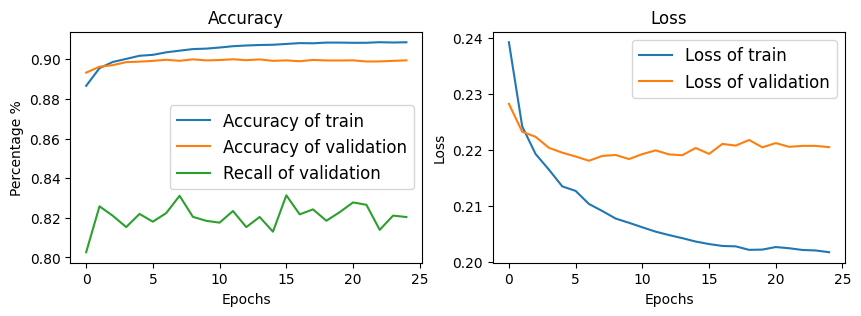

In [37]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [38]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.8199202401206444,
 'accuracy': 0.8994575068726092,
 'loss': 0.21937749612680477}

In [39]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]

110203 504920


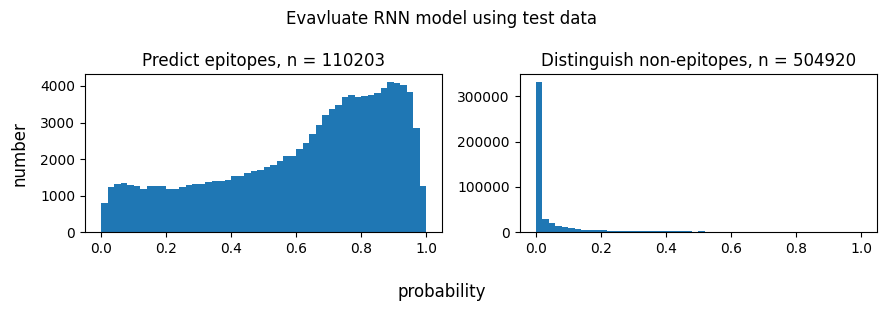

In [40]:
MyEvaluate.plot_prob(pred_test)

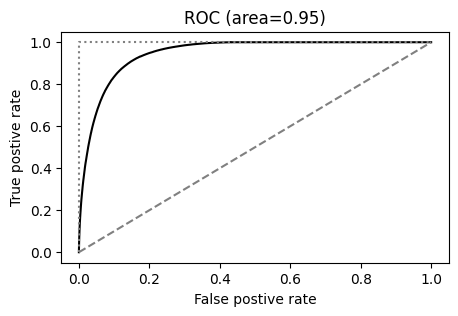

In [41]:
MyEvaluate.plot_roc(pred_test)

In [42]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_notLeu.pth')

## has Leu

In [43]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep Cys
select = df11[0].apply(lambda x: True if 'L' in x else False)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

(1865242, 2) (1865242, 2)
0
True     1314625
False     550617
Name: count, dtype: int64
(1314625, 2)


In [44]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)

(3839620, 2)


In [45]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('random', 'LQHRPKYTD')
Counter({'other': 1592996, 'epitope': 1314625, 'random': 931999})


In [46]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('epitope', 'EALRKMGL')
split data:  2303772 767924 767924

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: HKKAAFQD ['H', 'K', 'K', 'A', 'A', 'F', 'Q', 'D']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 2725438), ('A', 1917050), ('S', 1914090), ('E', 1763317), ('G', 1740526), ('V', 1705026), ('K', 1568590), ('P', 1545963), ('R', 1493019), ('T', 1486425), ('D', 1416444), ('I', 1324299), ('Q', 1275273), ('N', 1173169), ('F', 1126042), ('Y', 961374), ('H', 849426), ('M', 769189), ('C', 732602), ('W', 602190), ('X', 1570), ('U', 41), ('Z', 31), ('B', 23), ('J', 4)])
counts of input: [955608, 788725, 559439]

## Step 3 encoding: encoding each unique token into integers...


In [47]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [48]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8154 val_acc: 0.8234, val_recall: 0.8212
Epoch 1 acc: 0.8267 val_acc: 0.8259, val_recall: 0.8135
Epoch 2 acc: 0.8296 val_acc: 0.8288, val_recall: 0.8151
Epoch 3 acc: 0.8306 val_acc: 0.8302, val_recall: 0.8164
Epoch 4 acc: 0.8299 val_acc: 0.8204, val_recall: 0.8102
Epoch 5 acc: 0.8308 val_acc: 0.8302, val_recall: 0.8185
Epoch 6 acc: 0.8330 val_acc: 0.8310, val_recall: 0.8203
Epoch 7 acc: 0.8346 val_acc: 0.8318, val_recall: 0.8190
Epoch 8 acc: 0.8348 val_acc: 0.8300, val_recall: 0.8186
Epoch 9 acc: 0.8360 val_acc: 0.8312, val_recall: 0.8183
Epoch 10 acc: 0.8364 val_acc: 0.8315, val_recall: 0.8238
Epoch 11 acc: 0.8376 val_acc: 0.8326, val_recall: 0.8189
Epoch 12 acc: 0.8378 val_acc: 0.8293, val_recall: 0.8147
Epoch 13 acc: 0.8374 val_acc: 0.8303, val_recall: 0.8201
Epoch 14 acc: 0.8362 val_acc: 0.8314, val_recall: 0.8215
Epoch 15 acc: 0.8378 val_acc: 0.8315, val_recall: 0.8224
Epoch 16 acc: 0.8386 val_acc: 0.8323, val_recall: 0.8213
Epoch 17 acc: 0.8397 val_acc: 0.8316, val

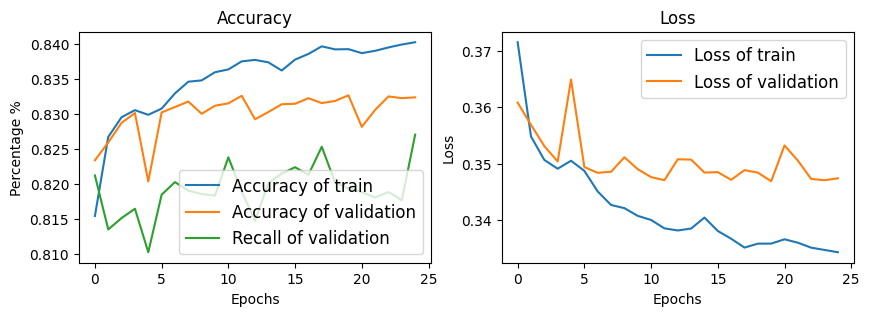

In [49]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [50]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.8279530947474295,
 'accuracy': 0.8330407696594976,
 'loss': 0.3472843874953583}

In [51]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,SDLKRRSTQ,5.605497e-02,other
1,DHIFNYQKI,1.795151e-14,random
2,VKDQMGWKCHAGPLFSC,1.747922e-02,random
3,QPGGKMVAA,9.495127e-14,other
4,WAWPGFQRLQ,5.203117e-02,other


263015 504909


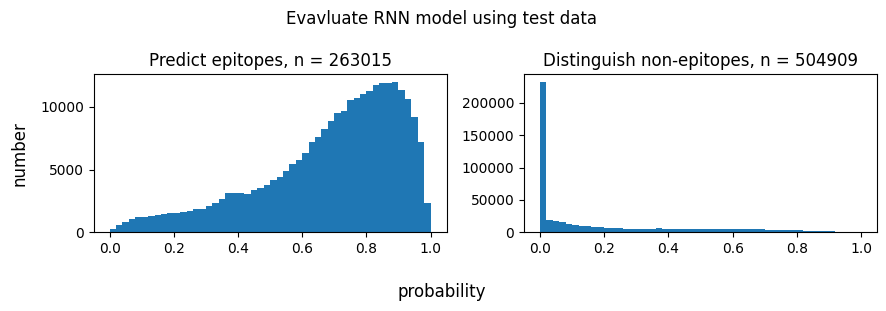

In [52]:
MyEvaluate.plot_prob(pred_test)

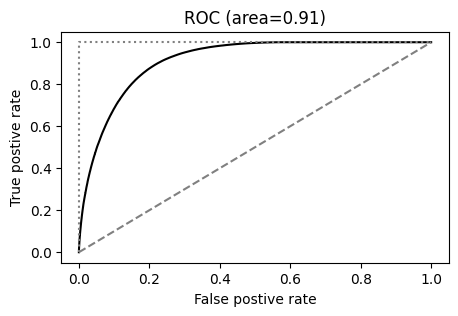

In [53]:
MyEvaluate.plot_roc(pred_test)

In [54]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_Leu.pth')